#### Download the pre-trained Glove word embeddings

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-07-22 08:24:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-22 08:24:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-22 08:24:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

#### Unzip the downloaded word embeddings

In [2]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Import the required libraries

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM,Embedding
from keras import optimizers
from keras import metrics
import pandas as pd
from matplotlib import pyplot

Using TensorFlow backend.


### Inputing the dataset

In [4]:
sf = pd.read_csv(r'..../Downloads/IMDB Dataset.csv')
sf.sentiment = [0 if each =="negative" else 1 for each in sf.sentiment]

### Preprocessing the dataset

This step includes :-

i) Using Tokenizer to convert words to vectors

ii) Splitting the dataset into train and test set

In [5]:
size= 40000
tokenizer = Tokenizer(num_words = None,oov_token="<OOV>")
tokenizer.fit_on_texts(sf['review'][:size])
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(sf['review'][:size])
sequences_train = np.array(sequences_train)
sequences_train = pad_sequences(sequences_train, maxlen=250, padding="pre", truncating="post")

sequences_test = tokenizer.texts_to_sequences(sf['review'][size:])
sequences_test = np.array(sequences_test)
sequences_test = pad_sequences(sequences_test, maxlen=250, padding="pre", truncating="post")

x_train = sequences_train
y_train = np.array(sf['sentiment'][:size])
y_train = y_train.reshape((y_train.shape[0],1))

x_test = sequences_test
y_test = np.array(sf['sentiment'][size:])
y_test= y_test.reshape((y_test.shape[0],1))

### Preparaing the weight matrix of embedding layer

In [6]:
size_of_vocabulary = len(word_index) + 1
embeddings_index = dict()
f = open(r'glove.6B.300d.txt',encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


## Initializing the model

We are using :-

i) Sequential model with one non trainable embedding layer, two LSTM layer and one dense layer

ii) Dropout to prevent overfitting

In [7]:
model = Sequential()
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=250,trainable=False)) 
model.add(LSTM(64,return_sequences=True,dropout=0.5,recurrent_dropout=0.5))
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5))
model.add(Dense(1,activation='sigmoid'))

### Compiling the model

We are using binary cross entropy loss function and accuracy for metrics evalation with adam optimizer

In [8]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

### Fitting model

Epoch 1/200
40000/40000 [==============================] - 56s 1ms/step - loss: 0.6765 - acc: 0.5657
Epoch 2/200
40000/40000 [==============================] - 54s 1ms/step - loss: 0.6221 - acc: 0.6563
Epoch 3/200
40000/40000 [==============================] - 53s 1ms/step - loss: 0.5860 - acc: 0.6963
Epoch 4/200
40000/40000 [==============================] - 54s 1ms/step - loss: 0.5616 - acc: 0.7162
Epoch 5/200
40000/40000 [==============================] - 53s 1ms/step - loss: 0.5469 - acc: 0.7330
Epoch 6/200
40000/40000 [==============================] - 53s 1ms/step - loss: 0.5367 - acc: 0.7359
Epoch 7/200
40000/40000 [==============================] - 53s 1ms/step - loss: 0.5279 - acc: 0.7483
Epoch 8/200
40000/40000 [==============================] - 53s 1ms/step - loss: 0.5157 - acc: 0.7548
Epoch 9/200
40000/40000 [==============================] - 54s 1ms/step - loss: 0.5108 - acc: 0.7561
Epoch 10/200
40000/40000 [==============================] - 55s 1ms/step - loss: 0.5031 - a

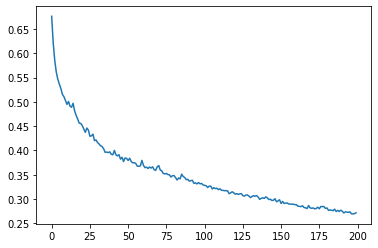

In [9]:
history = model.fit(x_train,y_train,epochs=200,batch_size=1024)
pyplot.plot(history.history['loss'])
pyplot.legend()
pyplot.show()

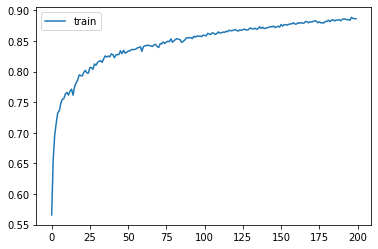

In [10]:
pyplot.plot(history.history['acc'], label='train')
pyplot.legend()
pyplot.show()

### Evaluating the performance of our trained model on test set

In [11]:
loss,acc=model.evaluate(x_test,y_test)
print('Loss on test set :',loss)
print('Accuracy on test set :',acc)

10000/10000 [==============================] - 21s 2ms/step
Loss on test set : 0.23500430617332457
Accuracy on test set : 0.90829998254776


#### Evaluating performance on random tokens of data

In [12]:
def demo(dem):
    demo_s = tokenizer.texts_to_sequences(dem)
    demo_s = np.array(demo_s)
    demo_s = pad_sequences(demo_s, maxlen=250, padding="pre", truncating="post")
    return model.predict(demo_s)

In [13]:
strn = ['it was a great movie with great story and awesome cast']
demo(strn)

array([[0.9914539]], dtype=float32)

### Saving our model

In [14]:
model.save('model.h5')